# Custom Image Reader

This demonstrates defining your own custom image reader class to work with the LoadImage transform. This will let you load your own image types that aren't directly supported by MONAI. Note this is for version 0.6 and in subsequent versions the underlying implementation of LoadImage will change slightly.

In [1]:
from typing import Sequence, Union

import numpy as np
import matplotlib.pyplot as plt

from monai.data.image_reader import ImageReader
from monai.transforms import Compose, LoadImage, AddChannel
from monai.data import create_test_image_2d, Dataset, DataLoader
from monai.data.utils import is_supported_format, ensure_tuple

Here we will save a few tif files to a temp directory using PIL:

In [2]:
import tempfile
from PIL import Image

root_dir = tempfile.mkdtemp()
filenames = []

for i in range(5):
    im, _ = create_test_image_2d(256, 256, num_objs=25, rad_max=50)

    im_filename = f"{root_dir}/im{i}.tif"
    filenames.append(im_filename)

    pim = Image.fromarray(im)
    pim.save(im_filename)

The `ImageReader` class defines an interface for loading image data from filenames. We provide implementations of its methods below to load tif files one at a time or multiples at once. The `PILReader` already exists and this would be a good place to look to see a more involved implementation of this type of class.

In [3]:
class TifReader(ImageReader):
    """
    Load tif file or files from provided path. This is a simplified example that lacks many features present in other image readers, 
    refer to MONAI code to see how to implement a more complete image reader. 
    """

    def verify_suffix(self, filename: Union[Sequence[str], str]) -> bool:
        """
        Verify whether the specified file or files format is supported by the reader.
        """
        return is_supported_format(filename, ["tiff", "tif"])

    def read(self, data: Union[Sequence[str], str, np.ndarray], **kwargs):
        """
        Read image data from specified file or files.
        Note that the returned object is PIL image or list of PIL image.
        """

        filenames: Sequence[str] = ensure_tuple(data)
        images = [Image.open(name) for name in filenames]

        return images if len(filenames) > 1 else images[0]

    def get_data(self, img):
        """
        Extract data array and meta data from loaded data and return them. This simplifies the process for 
        demonstration reasons, refer to PILReader for a more complete implementation.
        
        Args:
            img: a PIL Image object loaded from a file or a list of PIL Image objects.
        """
        img_array: List[np.ndarray] = []

        for i in ensure_tuple(img):
            data = np.asarray(i)
            img_array.append(data)

        metadata = {
            "format": i.format,
            "mode": i.mode,
            "width": i.width,
            "height": i.height,
            "spatial_shape": np.asarray((i.width, i.height)),
        }

        final_image = img_array[0] if len(img_array) == 1 else np.stack([i[None] for i in img_array], 0)

        return final_image, metadata

We can then define a transform pipeline with `LoadImage` being provided an instance of `TifReader` as its `reader` argument. This object will then be used to load file data:

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


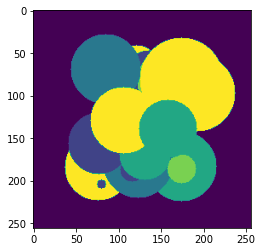

In [4]:
trans = Compose([LoadImage(reader=TifReader(), image_only=True), AddChannel()])

ds = Dataset(filenames, trans)
dl = DataLoader(ds, batch_size=1, num_workers=1)

for batch in dl:
    print(batch.shape)

plt.imshow(batch[0, 0])